#Generating a pre-trained model for detecting facial emotion

**About**

This notebook is for building, saving, and testing the convolutional neural network responsible for detecting positive / negative emotions from images.

**Data information**: all images are of cropped faces to maximise the ability for the model to generalise emotions. Without training on faces, the model would do much worse on unseen data. Therefore for the model to be optimal at detecting emotion, predictions must be made on an array faces - not full body images. 

**Label information:** positive / neural faces are labeled as 1, negative faces are labeled as 0.


## 1. Installing modules 

In [ ]:
!pip install kwargs  
!pip install cinit 
!pip install kaggle

  Created wheel for cinit: filename=cinit-0.1.0-py3-none-any.whl size=2483 sha256=b7b6e6677f3320dd9190d9f1609e4faf594b9678594cb71be2eadb554110df01
  Stored in directory: /root/.cache/pip/wheels/91/3f/1d/107e7a9f4fe2928b03f075369470090941f7d217bbaeab9aed
Successfully built cinit


## Kaggle API key set

You can generate your own API key via this link: https://www.kaggle.com/docs/api


In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "aparker99"
os.environ['KAGGLE_KEY'] = "33de133161492f6af373277f54ffa5f6"

## Downloading fer2013.csv database and unpacking it

Fer2013 is a dataset with around 30,000 grayscale facial images with size restricted to 48x48. 

Emotions are labeled as follows: 

0. Angry
1. Disgust
2. Fear
3. Happy
4. Sad
5. Surprise
6. Neutral 

Below are cells for downloading the dataset and then extracting it into a folder named dataset.

In [ ]:
!kaggle datasets download -d deadskull7/fer2013
!mkdir train

 84% 81.0M/96.6M [00:00<00:00, 149MB/s]
100% 96.6M/96.6M [00:00<00:00, 165MB/s]


In [ ]:
!unzip fer2013.zip -d dataset

Archive:  fer2013.zip
  inflating: dataset/fer2013.csv     


Number of training items: 28709

Public test items: 3589

Private test items: 3589 

## Importing libraries

In [ ]:
import sys  
import pandas as pd  
import numpy as np  
import tensorflow as tf
import keras 

from keras.models import Sequential  
from keras.layers import Dense, Dropout, Activation, Flatten  
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D  
from keras.losses import categorical_crossentropy  
from keras.regularizers import l2  
from keras.utils import np_utils  
from matplotlib import pyplot as plt
import json

### Dataset helper functions

**About**: 

`remap_emotion_into_positive_negative` is a function for remapping emotions into either 1 or 0 depending on whether the emotion is deemed as positive or not.

For the first versio of the model, I have decided to re-label emotions labeled as 0,1,2,4 as negative, and everything else as positive.

`load_data` loads all images and normalises them between 0.0 and 1.0 

In [ ]:
def get_number_of_negative_positive_samples(labels):
  values, counts = np.unique(labels, return_counts=True)
  print(counts)

# 
def remap_emotion_into_positive_negative(emotion):
  if (emotion in [0,1,2,4]):
    return 0
  else:
    return 1 

def load_data(df):
  # define input image width, height
  input_image_width, input_image_height = 48, 48  

  # create train, test arrays
  X_train, train_y, X_test, test_y = [], [], [], []  

  for index, row in df.iterrows():  
    val=row["pixels"].split(" ")  
    try:  
      remapped_emotion = remap_emotion_into_positive_negative(row["emotion"])

      # retrieve data and normalise 
      dat = np.array(val,'float32') / 255.0

      if 'Training' in row['Usage']:  
        X_train.append(dat)  
        train_y.append(remapped_emotion)  
      elif 'PublicTest' in row['Usage']:  
        X_test.append(dat)  
        test_y.append(remapped_emotion)  
    except:  
      print(f"error occured at index :{index} and row:{row}")  
    
    
  # cast training and testing to numpy array of type float32
  X_train = np.array(X_train,'float32')  
  train_y = np.array(train_y,'float32')  
  X_test  = np.array(X_test,'float32')  
  test_y  = np.array(test_y,'float32')  

  train_y = np_utils.to_categorical(train_y, num_classes=2)  
  test_y  = np_utils.to_categorical(test_y, num_classes=2)  
  
  X_train = X_train.reshape(X_train.shape[0], input_image_width, input_image_height, 1)  
  X_test = X_test.reshape(X_test.shape[0], input_image_width, input_image_height, 1)  

  return X_train, train_y, X_test, test_y


### Visualisation helper functions

In [ ]:
# get training histories 
def get_histories(history):
  history_dict = history.history
  return history_dict, history_dict["loss"], history_dict["val_loss"], history_dict["accuracy"], history_dict["val_accuracy"]

# plot training histories 
def plot_histories(hist, name="", stop_at=-1):
  
  # get histories
  history_dict, loss, val_loss, acc, val_acc = get_histories(hist)
  
  # trim if needed
  if (stop_at !=-1):
    loss = loss[:stop_at]
    val_loss = val_loss[:stop_at]
    acc = acc[:stop_at]
    val_acc = val_acc[:stop_at]

  epochs = range(1, len(loss) + 1)

  # create sub plots 
  fig, axs = plt.subplots(1, 2)
  fig.suptitle(f"{name} Results", fontsize=16)
  fig.set_size_inches(14, 6)

  # plot
  axs[0].plot(epochs, val_loss, color='purple', label = 'validation loss')
  axs[0].plot(epochs, loss, 'ko', label = 'training loss', markersize=1.5)

  # labels
  plt.setp(axs[0], xlabel='Epochs')
  plt.setp(axs[0], ylabel='Loss')
  axs[0].set_title('Training and validation loss')
  axs[0].legend()

  # plot 
  axs[1].plot(epochs, val_acc, color='purple', label = 'validation acc')
  axs[1].plot(epochs, acc, 'ko', label = 'training acc', marker="o", markersize=1.5)

  # labels 
  plt.setp(axs[1], xlabel='Epochs')
  plt.setp(axs[1], ylabel='Accuracy')
  axs[1].set_title('Training and validation accuracy')
  axs[1].legend()

  

### CNN Emotion recognition related functions 

For facial emotion detection, I have decided to use a class of neural networks known as Convolutional Neural Networks (CNN).

Convolutional Neural Networks are used for analysing imagery. They belong to the ever-expanding field of Computer Vision. This type of architecture was inspired by how the Visual Cortex in animals work. Neurons in a ConvNet respond to stimuli within a certain region of the visual field. When grouped, these fields overlap to respond to the entire region of the visual area.

The model that I have built has 4 convolutional layers, followed by 1 dense, fully connected layer, and then two output nodes using softmax activation.

**Functions** 

`setup_cnn` is a function that returns an instance of a compiled neural network.

`save_model_weights` saves the model and its weights as a .h5 file.

`train_model` fits the model to data.



In [ ]:
def setup_cnn():
  model = Sequential()
  # 1st cnn layer 
  model.add(
      Conv2D(32, (3, 3), 
        input_shape=(X_train.shape[1:]), 
        activation = 'relu')
  )
  model.add(MaxPooling2D(pool_size = (2, 2)))

  # 2nd cnn layer
  model.add(Conv2D(64, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.5))

  # 3rd cnn layer
  model.add(Conv2D(128, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.5))

  # 4th cnn layer
  model.add(Conv2D(128, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))

  # flatten
  model.add(Flatten())

  # 5th fully connected layer
  model.add(Dense(units = 64, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(units = 2, activation = 'softmax'))

  # Compiling the CNN
  model.compile(
      optimizer = 'adam', 
      loss = 'categorical_crossentropy', 
      metrics = ['accuracy']
  )

  return model

# function for training model
def train_model(model, X_train, train_y, X_test, test_y, epochs=30):
  return model.fit(
      X_train, train_y,  
      batch_size=64,  
      epochs=epochs,  
      verbose=1,  
      validation_data=(X_test, test_y),  
      shuffle=True
  )

# function for saving model as json and its weights
def save_model_weights(model):
  positive_negative_classifier_json = model.to_json()  
  with open("positive_negative_classifier.json", "w") as json_file:  
    json_file.write(positive_negative_classifier_json)  
  model.save("positive_negative_classifier.h5")

### Main code - loading data 


In [ ]:
# read dataset into pandas datafame
df = pd.read_csv('dataset/fer2013.csv')  

In [ ]:
# load training and testing data 
X_train, train_y, X_test, test_y = load_data(df) 

# get number of negative and positive samples 
get_number_of_negative_positive_samples(train_y)

[28709 28709]


### Training and then saving model for later use

In this cell the model is initialised, compiled, trained for 30 epochs for optimal performance, and then saved locally for later use.

Epoch 1/30
449/449 [==============================] - 21s 18ms/step - loss: 0.6902 - accuracy: 0.5348 - val_loss: 0.6825 - val_accuracy: 0.5656
Epoch 2/30
449/449 [==============================] - 7s 16ms/step - loss: 0.6785 - accuracy: 0.5759 - val_loss: 0.6744 - val_accuracy: 0.5809
Epoch 3/30
449/449 [==============================] - 8s 17ms/step - loss: 0.6698 - accuracy: 0.5927 - val_loss: 0.6636 - val_accuracy: 0.5982
Epoch 4/30
449/449 [==============================] - 8s 17ms/step - loss: 0.6653 - accuracy: 0.6019 - val_loss: 0.6596 - val_accuracy: 0.6021
Epoch 5/30
449/449 [==============================] - 7s 16ms/step - loss: 0.6587 - accuracy: 0.6102 - val_loss: 0.6541 - val_accuracy: 0.6197
Epoch 6/30
449/449 [==============================] - 7s 16ms/step - loss: 0.6503 - accuracy: 0.6199 - val_loss: 0.6381 - val_accuracy: 0.6386
Epoch 7/30
449/449 [==============================] - 7s 16ms/step - loss: 0.6334 - accuracy: 0.6360 - val_loss: 0.5999 - val_accuracy: 0.668

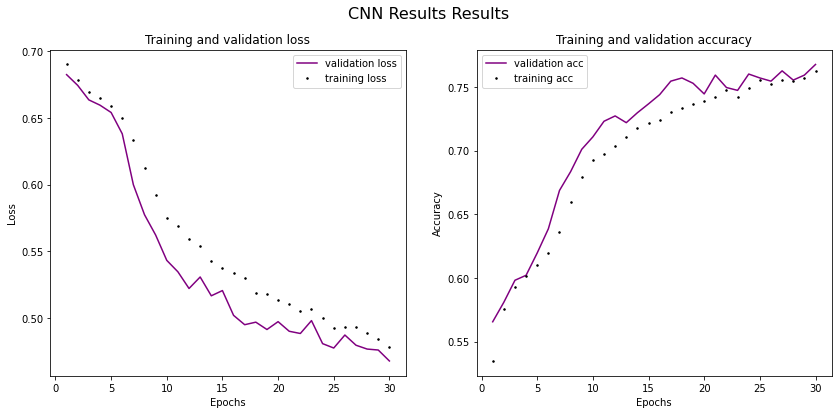

In [ ]:
# setting up and compiling cnn 
model = setup_cnn();

# train model for 30 epochs
history = train_model(model, X_train, train_y, X_test, test_y, epochs=30)

# plotting results 
plot_histories(history, name="CNN Results")

# saving model as a ".h5" file 
save_model_weights(model)

After running for 30 epochs, the model seemed to have converged to its optimal state. There appears to be no signs of overfitting or underfitting.

The final accuracy of the model leveled out at 76% on unseen data.

In [ ]:
model.evaluate(X_test, test_y)

113/113 [==============================] - 1s 7ms/step - loss: 0.4677 - accuracy: 0.7676


[0.4676959812641144, 0.7676233053207397]

## Loading saved model 

For testing purposes, we load the model from local storage and then evaluating it on a couple of images from the test set.

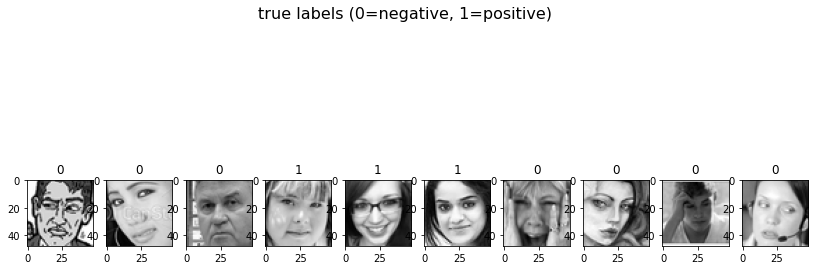

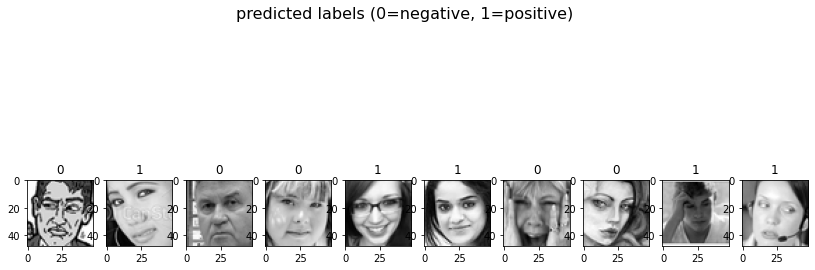

In [ ]:
load_model_name = "positive_negative_classifier.h5"

if not(os.path.isfile("positive_negative_classifier.h5")):
  raise ValueError("error: pre-trained model could not be found")
else:
  pretrained_model = tf.keras.models.load_model(load_model_name)

def show_images(images, image_dims, grid_size, title="", labels=[]):
  if (len(images) != grid_size[0] * grid_size[1]):
    print(len(images) , grid_size[0] * grid_size[1], "error - grid size does not match num of elements")
    return

  fig, axs = plt.subplots(grid_size[0], grid_size[1])
  fig.set_size_inches(14, 6)
  fig.suptitle(title, fontsize=16)

  for i, ax in enumerate(axs.ravel()):
    if (len(labels)==len(images)):
      ax.set_title(labels[i])

    # reshape pixels into an array of shape (48,48)
    pixels = images[i].reshape(48,48)

    # display image
    ax.imshow(pixels, cmap="gray")

show_images(X_test[0:10], (48,48), (1,10), title="true labels (0=negative, 1=positive)", labels=np.argmax(test_y[0:10], axis=1))
show_images(X_test[0:10], (48,48), (1,10), title="predicted labels (0=negative, 1=positive)", labels=np.argmax(pretrained_model.predict(X_test[0:10]), axis=1))
